# CSC2516H: Deep Learning Final Project 

Kishore Basu, Toufic (TJ) Ayoub, Timothy (Jordan) Regis




# Load Python Libraries

In [ ]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import matplotlib
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, LSTM, RNN, GRU 
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow as tf 
tfd = tfp.distributions		# TensorFlow Probability distributions
tfpl = tfp.layers			# TensorFlow Probability layers
from google.colab import files
from tensorflow import keras
from tensorflow.keras.layers import Attention
import seaborn as sns

In [ ]:
! pip install alpha_vantage -q

# pip install numpy
import numpy as np

# pip install torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# pip install alpha_vantage
from alpha_vantage.timeseries import TimeSeries 

print("All libraries loaded")
     

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 2.8 MB/s eta 0:00:00
All libraries loaded


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Flatten
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sqlite3
import pandas as pd
import math
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from datetime import datetime

#For reproducability
from numpy.random import seed

<ipython-input-3-5f196e70b60e>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
# Load in Priors and Posteriors for weights
def prior_fn(kernel_size, bias_size, dtype = None):
  n = kernel_size + bias_size;
  prior = tf.keras.Sequential([
    tfpl.DistributionLambda(lambda t:
    tfd.MultivariateNormalDiag(loc = tf.zeros(n), 
                  scale_diag = tf.ones(n)))
  ])
  return prior
  # def prior_fn()

def posterior_fn(kernel_size, bias_size, dtype = None):
  #print(kernel_size, bias_size)
  n = kernel_size + bias_size
  posterior = tf.keras.Sequential([
    tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), 
              dtype=dtype),
    tfpl.IndependentNormal(n)
  ])
  return posterior
  # def posterior_fn()

# Initialize Configurations

In [ ]:
config = {
    "data": {
        "data_link": "MSFT_FirstRateDatacom1.txt",
        "window_size": 20,
        "train_split_size": 0.80,
        "num_minutes":5,
        "data_time_frame": 10000,
    }, 
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
        "color_true_stock":"red",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 128,
        "num_epoch": 50,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    },
    "lstm":{
        "batch_size":32,
        "num_epochs":50,
        "learning_rate":1e-3,
        "plot_output":True,
        "num_ints":20,
        "lstm_units":100,
        "lstm_dropout":0.3,
    },
    "lstm_att":{
      "batch_size":32,
      "num_epochs":50,
      "learning_rate":1e-3,
      "plot_output":True,
      "num_ints":20,
      "lstm_units":100,
      "lstm_dropout":0.3,
    },
    "gru": {
        "batch_size":32,
        "num_epoch":50,
        "learning_rate":1e-3,
        "plot_output":True,
        "num_ints":20,
        "gru_units":100,
        "gru_dropout":0.3,
    }
}

# Data preparation: normalizing data

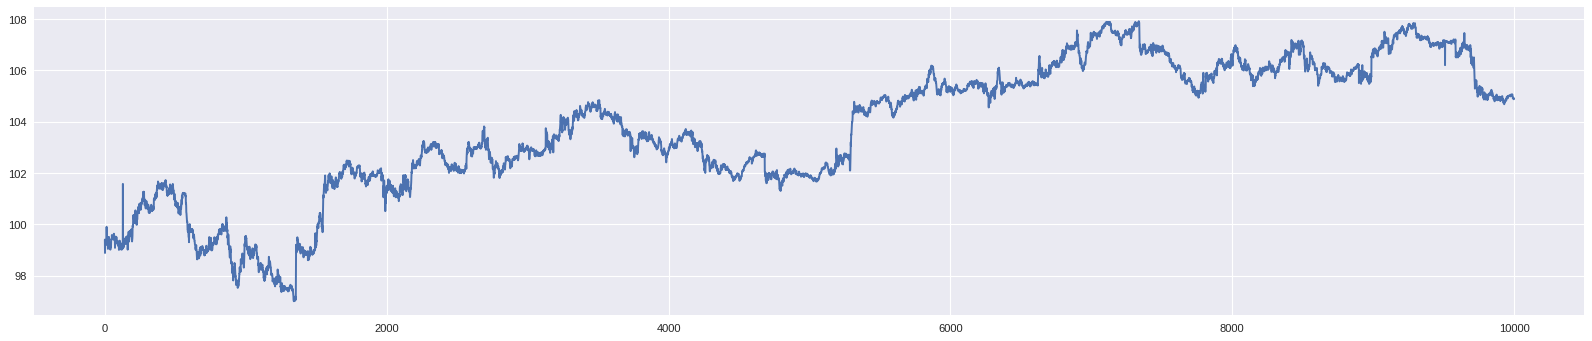

In [ ]:
def split_data(config, plot = True):

    data = pd.read_csv(config['data']['data_link'], header = None)
    data.columns = ["Date/Time", "Open", "High", "Low", "Close", "Volume"]
    # data.head()
    upper = config['data']['data_time_frame']
    data = data.iloc[0:upper, :]

    num_minutes = config['data']['num_minutes']
    time = data[['Date/Time']]

    price = data[['Close']]

    if plot:
        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(price.to_numpy())
        # xticks = time #[data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
        # x = np.arange(0,len(xticks))
        # plt.xticks(x, xticks, rotation='vertical')
        # plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
        #plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.show()


    return time, price

data_date, data_close_price = split_data(config)

In [ ]:
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0))
        self.sd = np.std(x, axis=(0))
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

# normalize
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(data_close_price)

In [ ]:
num_data_points = len(normalized_data_close_price)

# Data preparation: generating testing and validation sets

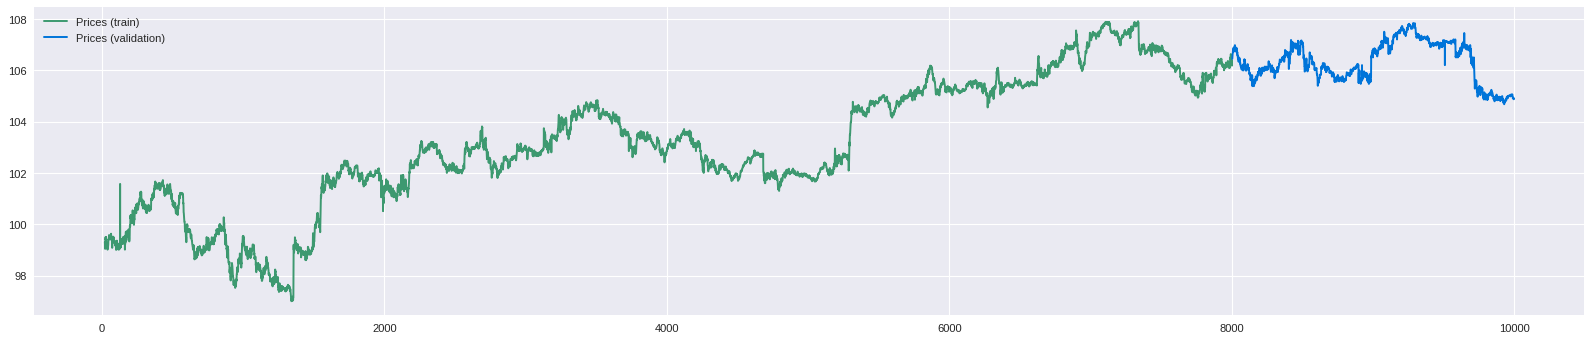

In [ ]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row,window_size), strides=(x.strides[0],x.strides[0]))
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    # use the next day as label
    output = x[window_size:]
    return output

def prepare_data(normalized_data_close_price, config, plot=False):
    data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
    data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

    # split dataset

    split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
    data_x_train = data_x[:split_index]
    data_x_val = data_x[split_index:]
    data_y_train = data_y[:split_index]
    data_y_val = data_y[split_index:]

    if plot:
        # prepare data for plotting

        to_plot_data_y_train = np.zeros(num_data_points)
        to_plot_data_y_val = np.zeros(num_data_points)

        to_plot_data_y_train[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = (data_y_train * scaler.sd.to_numpy()[0] + scaler.mu.to_numpy()[0])[:, 0]
        to_plot_data_y_val[split_index+config["data"]["window_size"]:] = (data_y_val * scaler.sd.to_numpy()[0] + scaler.mu.to_numpy()[0])[:, 0]

        to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
        to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

        ## plots

        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
        plt.plot(to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])
        # xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
        # x = np.arange(0,len(xticks))
        # plt.xticks(x, xticks, rotation='vertical')
        # plt.title("Daily close prices for " + config["alpha_vantage"]["symbol"] + " - showing training and validation data")
        # plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

    return split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen

split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen = prepare_data(normalized_data_close_price.to_numpy(), config, plot=config["plots"]["show_plots"])


In [ ]:
data_y_train.shape

(7984, 1)

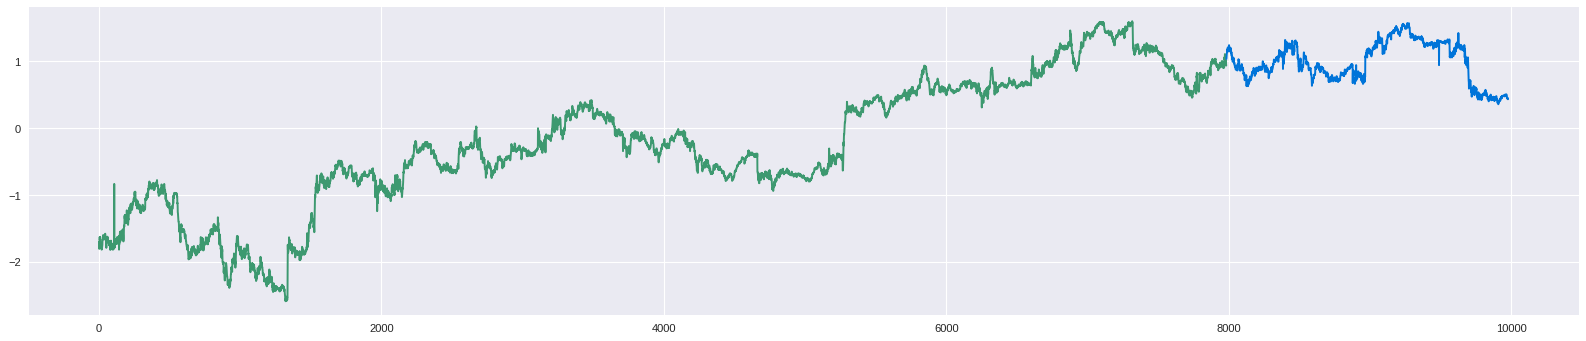

In [ ]:
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))

plt.plot(np.arange(0,len(data_y_train)), data_y_train, color = config["plots"]["color_train"])
plt.plot(np.arange(len(data_y_train), len(data_y_train) + len(data_y_val)), data_y_val, color = config["plots"]["color_val"])

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

Train data shape (7984, 20, 1) (7984, 1)
Validation data shape (1996, 20, 1) (1996, 1)


In [ ]:
def plot_inferences(model, num_ints):
  train_int = np.zeros((dataset_train.x.shape[0], num_ints))
  train_val = np.zeros((dataset_val.x.shape[0], num_ints))

  for i in range(num_ints):
    predicted_train = model(dataset_train.x)
    predicted_val = model(dataset_val.x)

    train_int[:, i] = predicted_train[:, 0] 
    train_val[:, i] = predicted_val[:, 0] 


  train_mean = np.mean(train_int, axis = 1)
  train_sd = np.std(train_int, axis = 1)

  val_mean = np.mean(train_val, axis = 1)
  val_sd = np.std(train_val, axis = 1)


  fig = figure(figsize=(25, 5), dpi=80)
  fig.patch.set_facecolor((1.0, 1.0, 1.0))

  plt.errorbar(x = np.arange(0,len(predicted_train)), 
              y = train_mean, 
              yerr = 1.96*train_sd,
              color = config["plots"]["color_train"])

  plt.errorbar(x = np.arange(len(predicted_train), len(predicted_train) + len(predicted_val)), 
              y = val_mean, 
              yerr = 1.96*val_sd,
              color = config["plots"]["color_train"])
  plt.plot(np.arange(len(predicted_train), len(predicted_train) + len(predicted_val)), 
              val_mean, color = "black")
  plt.plot(dataset_train.y, color = config["plots"]["color_true_stock"], linestyle = "dotted", alpha = 0.4)
  plt.plot(np.arange(len(predicted_train), len(predicted_train) + len(predicted_val)),
           dataset_val.y, color = config["plots"]["color_true_stock"], 
           linestyle = "dotted", alpha = 0.4)

In [ ]:
def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-2, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

# LSTM 

In [ ]:
LSTMModel = tf.keras.Sequential([
    LSTM(100, return_sequences=True, input_shape = (data_x_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(100, return_sequences=False), 
    Dropout(0.3),
    # tfp.layers.DenseVariational(
    # 50,
    # make_posterior_fn = posterior_fn,
    # make_prior_fn = prior_fn),
    Dense(1)
])
LSTMModel.compile(optimizer = 'adam', loss = 'mean_squared_error')
LSTMModel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 20, 100)           40800     
                                                                 
 dropout_4 (Dropout)         (None, 20, 100)           0         
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = LSTMModel.fit(
    data_x_train,
    data_y_train, epochs = 50,
    batch_size = 64, 
    verbose = 1
)

Epoch 1/50
125/125 [==============================] - 15s 86ms/step - loss: 0.0479
Epoch 2/50
125/125 [==============================] - 10s 80ms/step - loss: 0.0113
Epoch 3/50
125/125 [==============================] - 13s 101ms/step - loss: 0.0111
Epoch 4/50
125/125 [==============================] - 13s 101ms/step - loss: 0.0108
Epoch 5/50
125/125 [==============================] - 16s 125ms/step - loss: 0.0093
Epoch 6/50
125/125 [==============================] - 12s 97ms/step - loss: 0.0091
Epoch 7/50
125/125 [==============================] - 17s 139ms/step - loss: 0.0094
Epoch 8/50
125/125 [==============================] - 16s 131ms/step - loss: 0.0087
Epoch 9/50
125/125 [==============================] - 17s 138ms/step - loss: 0.0083
Epoch 10/50
125/125 [==============================] - 14s 110ms/step - loss: 0.0086
Epoch 11/50
125/125 [==============================] - 15s 119ms/step - loss: 0.0088
Epoch 12/50
125/125 [==============================] - 13s 102ms/step - loss:

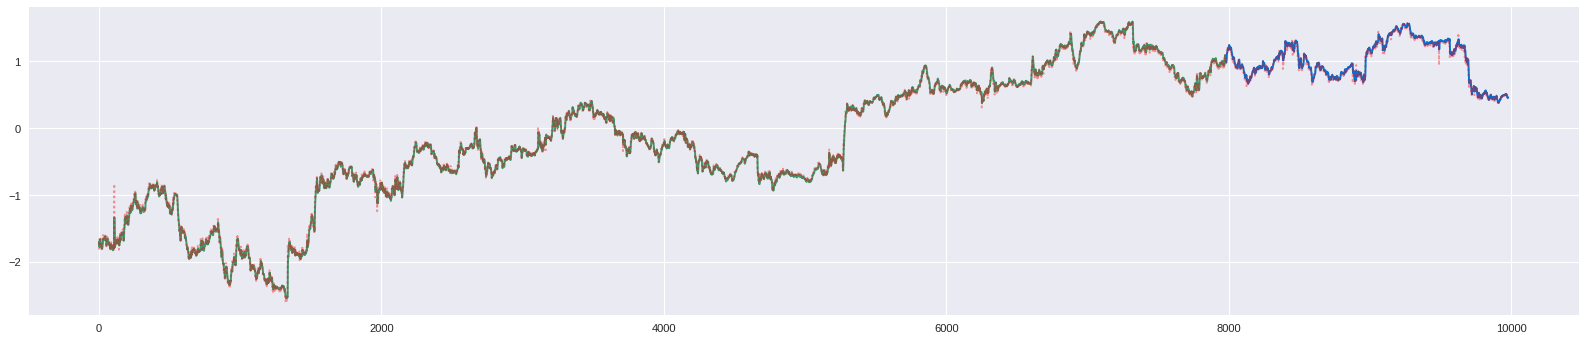

In [ ]:
predicted_train = LSTMModel(dataset_train.x)
predicted_val = LSTMModel(dataset_val.x)

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))

plt.plot(np.arange(0,len(predicted_train)), predicted_train, color = config["plots"]["color_train"])
plt.plot(np.arange(len(predicted_train), len(predicted_train) + len(predicted_val)), predicted_val, color = config["plots"]["color_val"])
plt.plot(dataset_train.y, color = "red", linestyle = "dotted", alpha = 0.4)
plt.plot(np.arange(len(predicted_train), len(predicted_train) + len(predicted_val)),dataset_val.y, color = config["plots"]["color_true_stock"], linestyle = "dotted", alpha = 0.4)

# Bayesian Neural Network (LSTM)

In [ ]:
LSTMBayes = tf.keras.Sequential([
    LSTM(config["lstm"]["lstm_units"], return_sequences=True, input_shape = (data_x_train.shape[1], 1)),
    Dropout(config["lstm"]["lstm_dropout"]),
    LSTM(config["lstm"]["lstm_units"]), 
    Dropout(config["lstm"]["lstm_dropout"]),
    tfp.layers.DenseVariational(
    units = config["lstm"]["lstm_units"],
    make_posterior_fn = posterior_fn,
    make_prior_fn = prior_fn,
    kl_weight = 1/data_x_train.shape[0]),
    Dense(1)
])
LSTMBayes.compile(optimizer = keras.optimizers.Adam(learning_rate=config["lstm"]["learning_rate"]),
                  loss = 'mean_squared_error')
LSTMBayes.summary()

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 20, 100)           40800     
                                                                 
 dropout_2 (Dropout)         (None, 20, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_variational (DenseVar  (None, 100)              20200     
 iational)                                                       
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                      

In [ ]:
history = LSTMBayes.fit(
    data_x_train,
    data_y_train, epochs = config["lstm"]["num_epochs"],
    batch_size = config["lstm"]["batch_size"], 
    verbose = 1
)

Epoch 1/50
250/250 [==============================] - 11s 28ms/step - loss: 1.2683
Epoch 2/50
250/250 [==============================] - 7s 28ms/step - loss: 0.8285
Epoch 3/50
250/250 [==============================] - 7s 26ms/step - loss: 0.5872
Epoch 4/50
250/250 [==============================] - 8s 31ms/step - loss: 0.4026
Epoch 5/50
250/250 [==============================] - 6s 26ms/step - loss: 0.3083
Epoch 6/50
250/250 [==============================] - 7s 28ms/step - loss: 0.2510
Epoch 7/50
250/250 [==============================] - 7s 28ms/step - loss: 0.2023
Epoch 8/50
250/250 [==============================] - 7s 27ms/step - loss: 0.1723
Epoch 9/50
250/250 [==============================] - 7s 29ms/step - loss: 0.1548
Epoch 10/50
250/250 [==============================] - 6s 26ms/step - loss: 0.1413
Epoch 11/50
250/250 [==============================] - 7s 29ms/step - loss: 0.1349
Epoch 12/50
250/250 [==============================] - 6s 26ms/step - loss: 0.1289
Epoch 13/50


In [ ]:
if config["lstm"]["plot_output"]:
  plot_inferences(LSTMBayes, num_ints = config["lstm"]["num_ints"])

20

### Save Model (Optional)

In [ ]:
LSTMBayes.save('LSTMBayesModelMSFT')

In [ ]:
# Download 
LSTMBayes.save('LSTMBayesModelMSFT')
!zip -r /content/LSTMBayesModelMSFT.zip /content/LSTMBayesModelMSFT
files.download("/content/LSTMBayesModelMSFT.zip")

  adding: content/LSTMBayesModelMSFT/ (stored 0%)
  adding: content/LSTMBayesModelMSFT/keras_metadata.pb (deflated 87%)
  adding: content/LSTMBayesModelMSFT/fingerprint.pb (stored 0%)
  adding: content/LSTMBayesModelMSFT/variables/ (stored 0%)
  adding: content/LSTMBayesModelMSFT/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/LSTMBayesModelMSFT/variables/variables.index (deflated 61%)
  adding: content/LSTMBayesModelMSFT/assets/ (stored 0%)
  adding: content/LSTMBayesModelMSFT/saved_model.pb (deflated 91%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Read in Model (Optional)

In [ ]:
modelTest = tf.keras.models.load_model('LSTMBayesModel')

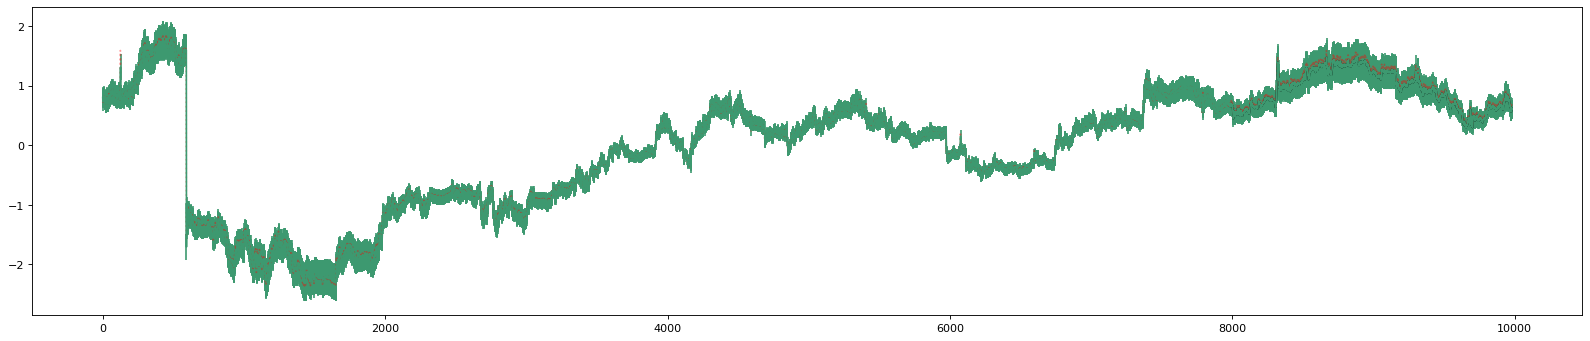

In [ ]:
num_ints = 20 

train_int = np.zeros((dataset_train.x.shape[0], num_ints))
train_val = np.zeros((dataset_val.x.shape[0], num_ints))



for i in range(num_ints):
  predicted_train = modelTest(dataset_train.x)
  predicted_val = modelTest(dataset_val.x)

  train_int[:, i] = predicted_train[:, 0] 
  train_val[:, i] = predicted_val[:, 0] 


  # plt.plot(normalized_data_close_price)
  # plt.plot(predicted_train)
  # plt.plot(predicted_val)

train_mean = np.mean(train_int, axis = 1)
train_sd = np.std(train_int, axis = 1)

val_mean = np.mean(train_val, axis = 1)
val_sd = np.std(train_val, axis = 1)

# plt.plot(np.arange(0,len(predicted_train)), predicted_train, color = config["plots"]["color_train"])
# plt.plot(np.arange(len(predicted_train), len(predicted_train) + len(predicted_val)), predicted_val, color = config["plots"]["color_val"])

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))

plt.errorbar(x = np.arange(0,len(predicted_train)), 
             y = train_mean, 
             yerr = 1.96*train_sd,
             color = config["plots"]["color_train"])

plt.errorbar(x = np.arange(len(predicted_train), len(predicted_train) + len(predicted_val)), 
             y = val_mean, 
             yerr = 1.96*val_sd,
             color = config["plots"]["color_train"])
plt.plot(np.arange(len(predicted_train), len(predicted_train) + len(predicted_val)), 
             val_mean, color = "black")
plt.plot(dataset_train.y, color = "red", linestyle = "dotted", alpha = 0.4)
plt.plot(np.arange(len(predicted_train), len(predicted_train) + len(predicted_val)),dataset_val.y, color = "red", linestyle = "dotted", alpha = 0.4)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
with open('/content/gdrive/My Drive/LSTMBayesModel', 'w') as f:
  f.write('content')

In [ ]:
#!zip -r /content/LSTMBayesModel.zip /content/LSTMBayesModel

  adding: content/LSTMBayesModel/ (stored 0%)
  adding: content/LSTMBayesModel/assets/ (stored 0%)
  adding: content/LSTMBayesModel/saved_model.pb (deflated 91%)
  adding: content/LSTMBayesModel/fingerprint.pb (stored 0%)
  adding: content/LSTMBayesModel/keras_metadata.pb (deflated 86%)
  adding: content/LSTMBayesModel/variables/ (stored 0%)
  adding: content/LSTMBayesModel/variables/variables.index (deflated 61%)
  adding: content/LSTMBayesModel/variables/variables.data-00000-of-00001 (deflated 8%)


# LSTM with Attention

In [ ]:

inputs = keras.Input(shape=(data_x_train.shape[1], 1))
x = LSTM(config["lstm_att"]["lstm_units"], return_sequences=True)(inputs)
# x = tf.keras.layers.BatchNormalization()(x) # Extra
x = Dropout(config["lstm_att"]["lstm_dropout"])(x)
x = LSTM(config["lstm_att"]["lstm_units"], return_sequences=False)(x)
x = Dropout(config["lstm_att"]["lstm_dropout"])(x)
attention = Attention()(inputs=[x, x], use_causal_mask=True)
x = Dense(50)(attention)
# x = Dense(50)(x)
x = Dropout(config["lstm_att"]["lstm_dropout"])(x)
x = tfp.layers.DenseVariational(units = 100,make_posterior_fn = posterior_fn,make_prior_fn = prior_fn,kl_weight = 1/data_x_train.shape[0])(x)
x = Dense(1)(x)
LSTMBayesAtt = keras.Model(inputs=inputs, outputs=x)
LSTMBayesAtt.compile(optimizer='adam', loss='mean_squared_error')
LSTMBayesAtt.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 20, 1)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 20, 100)      40800       ['input_2[0][0]']                
                                                                                                  
 dropout_3 (Dropout)            (None, 20, 100)      0           ['lstm_2[0][0]']                 
                                                                                                  
 lstm_3 (LSTM)                  (None, 100)          80400       ['dropout_3[0][0]']              
                                                                                              

In [ ]:
history = LSTMBayesAtt.fit(
    data_x_train,
    data_y_train, epochs = config["lstm_att"]["num_epochs"],
    batch_size = config["lstm_att"]["batch_size"], 
    verbose = 1
)

Epoch 1/50
250/250 [==============================] - 26s 52ms/step - loss: 1.5566
Epoch 2/50
250/250 [==============================] - 11s 44ms/step - loss: 1.0590
Epoch 3/50
250/250 [==============================] - 11s 44ms/step - loss: 0.7010
Epoch 4/50
250/250 [==============================] - 12s 47ms/step - loss: 0.4992
Epoch 5/50
250/250 [==============================] - 12s 47ms/step - loss: 0.3540
Epoch 6/50
250/250 [==============================] - 12s 47ms/step - loss: 0.2844
Epoch 7/50
250/250 [==============================] - 14s 57ms/step - loss: 0.2316
Epoch 8/50
250/250 [==============================] - 15s 58ms/step - loss: 0.1955
Epoch 9/50
250/250 [==============================] - 12s 47ms/step - loss: 0.1855
Epoch 10/50
250/250 [==============================] - 12s 47ms/step - loss: 0.1730
Epoch 11/50
250/250 [==============================] - 12s 47ms/step - loss: 0.1419
Epoch 12/50
250/250 [==============================] - 12s 47ms/step - loss: 0.1347
E

In [ ]:
if config["lstm_att"]["plot_output"]:
  plot_inferences(LSTMBayesAtt, num_ints = config["lstm_att"]["num_ints"])

In [ ]:
# Download 
LSTMBayesAtt.save('LSTMBayesModelAAPL_2')
!zip -r /content/LSTMBayesModelAAPL_2.zip /content/LSTMBayesModelAAPL_2
files.download("/content/LSTMBayesModelAAPL_2.zip")

# GRU (And Bayesian)

In [ ]:
GRUBayes = tf.keras.Sequential([
    GRU(config["gru"]["gru_units"], return_sequences=True, input_shape = (data_x_train.shape[1], 1)),
    Dropout(config["gru"]["gru_dropout"]),
    GRU(config["gru"]["gru_units"]), 
    Dropout(config["gru"]["gru_dropout"]),
    tfp.layers.DenseVariational(
    units = config["gru"]["gru_units"],
    make_posterior_fn = posterior_fn,
    make_prior_fn = prior_fn,
    kl_weight = 1/data_x_train.shape[0]),
    Dense(1)
    # tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1.))
])
GRUBayes.compile(optimizer = keras.optimizers.Adam(learning_rate=config["gru"]["learning_rate"]),
                 loss = 'mean_squared_error')
GRUBayes.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 20, 100)           30900     
                                                                 
 dropout_9 (Dropout)         (None, 20, 100)           0         
                                                                 
 gru_2 (GRU)                 (None, 100)               60600     
                                                                 
 dropout_10 (Dropout)        (None, 100)               0         
                                                                 
 dense_variational_4 (DenseV  (None, 100)              20200     
 ariational)                                                     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                      

In [ ]:
history = GRUBayes.fit(
    data_x_train,
    data_y_train, epochs = config["gru"]["num_epoch"],
    batch_size = config["gru"]["batch_size"], 
    verbose = 1
)

Epoch 1/50
250/250 [==============================] - 13s 30ms/step - loss: 1.4132
Epoch 2/50
250/250 [==============================] - 8s 32ms/step - loss: 0.9297
Epoch 3/50
250/250 [==============================] - 8s 33ms/step - loss: 0.5503
Epoch 4/50
250/250 [==============================] - 7s 29ms/step - loss: 0.4458
Epoch 5/50
250/250 [==============================] - 8s 32ms/step - loss: 0.3202
Epoch 6/50
250/250 [==============================] - 8s 33ms/step - loss: 0.2696
Epoch 7/50
250/250 [==============================] - 10s 38ms/step - loss: 0.2064
Epoch 8/50
250/250 [==============================] - 10s 41ms/step - loss: 0.1723
Epoch 9/50
250/250 [==============================] - 8s 32ms/step - loss: 0.1497
Epoch 10/50
250/250 [==============================] - 8s 32ms/step - loss: 0.1412
Epoch 11/50
250/250 [==============================] - 8s 31ms/step - loss: 0.1282
Epoch 12/50
250/250 [==============================] - 8s 32ms/step - loss: 0.1232
Epoch 13/5

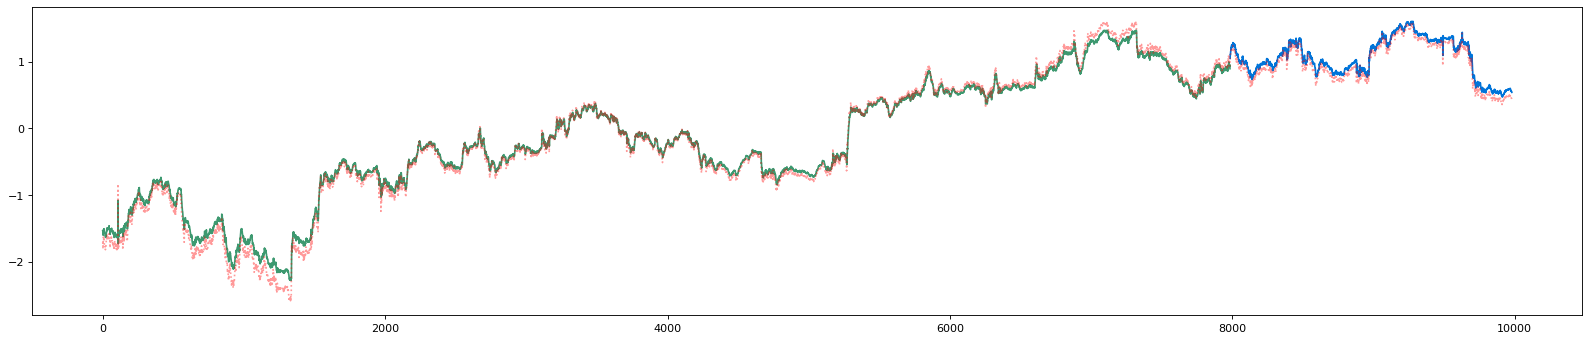

In [ ]:
predicted_train = GRUBayes(dataset_train.x)
predicted_val = GRUBayes(dataset_val.x)

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))

plt.plot(np.arange(0,len(predicted_train)), predicted_train, color = config["plots"]["color_train"])
plt.plot(np.arange(len(predicted_train), len(predicted_train) + len(predicted_val)), predicted_val, color = config["plots"]["color_val"])
plt.plot(dataset_train.y, color = "red", linestyle = "dotted", alpha = 0.4)
plt.plot(np.arange(len(predicted_train), len(predicted_train) + len(predicted_val)),dataset_val.y, color = "red", linestyle = "dotted", alpha = 0.4)

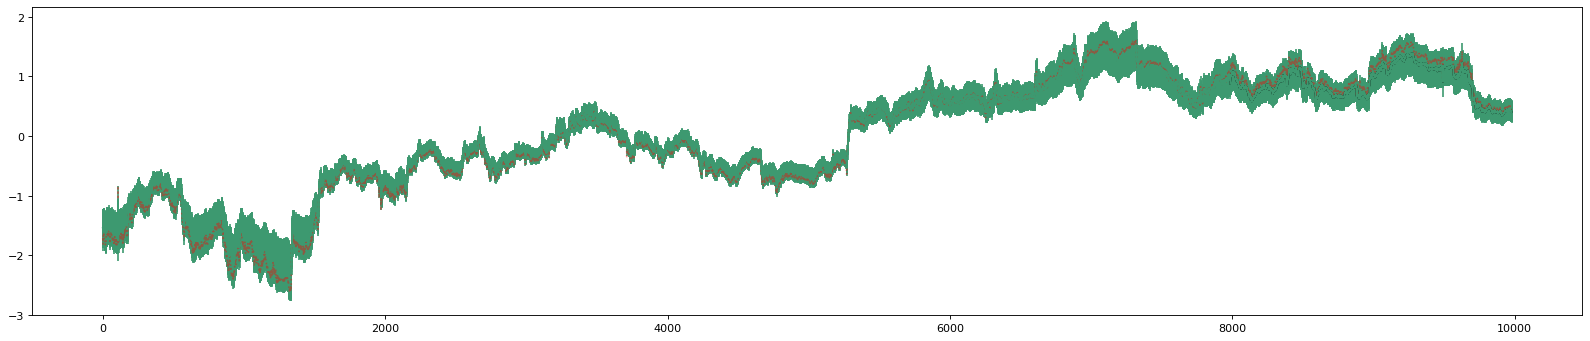

In [ ]:
if config["gru"]["plot_output"]:
  plot_inferences(GRUBayes, num_ints = config["gru"]["num_ints"])


### Save Model (Optional)

In [ ]:
# Download 
GRUBayes.save('GRUBayesMSFT')
!zip -r /content/GRUBayesMSFT.zip /content/GRUBayesMSFT
files.download("/content/GRUBayesMSFT.zip")

  adding: content/GRUBayesMSFT/ (stored 0%)
  adding: content/GRUBayesMSFT/keras_metadata.pb (deflated 87%)
  adding: content/GRUBayesMSFT/fingerprint.pb (stored 0%)
  adding: content/GRUBayesMSFT/variables/ (stored 0%)
  adding: content/GRUBayesMSFT/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/GRUBayesMSFT/variables/variables.index (deflated 61%)
  adding: content/GRUBayesMSFT/assets/ (stored 0%)
  adding: content/GRUBayesMSFT/saved_model.pb (deflated 91%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Transformer (Encoder Only)

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    
    # Normalization and Attention
    # "EMBEDDING LAYER"
    x = layers.LayerNormalization()(inputs) # epsilon=1e-6
    
    # "ATTENTION LAYER"
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    
    # FEED FORWARD Part - you can stick anything here or just delete the whole section - it will still work. 
    x = layers.LayerNormalization()(res) # epsilon=1e-6
    x = layers.Dense(ff_dim, activation = "elu")(x)#layers.Conv1D(filters=ff_dim, kernel_size=1, activation = "relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x) #layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    
    for _ in range(num_transformer_blocks):  # This is what stacks our transformer blocks
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = tfp.layers.DenseVariational(
            units = dim, 
            make_posterior_fn = posterior_fn, 
            make_prior_fn = prior_fn, 
            kl_weight = 1/data_x_train.shape[0],
            activation = "relu"
            )(x) #layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(1, activation="linear")(x) #this is a pass-through
    return keras.Model(inputs, outputs)


In [ ]:
callbacks = [
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.LearningRateScheduler(lr_scheduler)
            ]
input_shape = dataset_train.x.shape[1:]
print(input_shape)


(20, 1)


In [ ]:
EncoderOnlyModel2 = build_model(
    input_shape,
    head_size=15, # Embedding size for attention, 46
    num_heads=60,#60, # Number of attention heads
    ff_dim=55,#55, # Hidden layer size in feed forward network inside transformer
    num_transformer_blocks=2,
    mlp_units=[100],
    mlp_dropout=0.2,
    dropout=0.1,
)

EncoderOnlyModel2.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mean_squared_error"],
)


In [ ]:
history = EncoderOnlyModel2.fit(
    dataset_train.x,
    dataset_train.y,
    epochs=100,
    batch_size=512
  # callbacks=callbacks
)


Epoch 1/100
16/16 [==============================] - 26s 2s/step - loss: 0.2184 - mean_squared_error: 0.1884
Epoch 2/100
16/16 [==============================] - 25s 2s/step - loss: 0.2791 - mean_squared_error: 0.2485
Epoch 3/100
16/16 [==============================] - 25s 2s/step - loss: 0.2827 - mean_squared_error: 0.2514
Epoch 4/100
16/16 [==============================] - 25s 2s/step - loss: 0.2463 - mean_squared_error: 0.2154
Epoch 5/100
16/16 [==============================] - 23s 1s/step - loss: 0.2015 - mean_squared_error: 0.1704
Epoch 6/100
16/16 [==============================] - 25s 2s/step - loss: 0.1665 - mean_squared_error: 0.1358
Epoch 7/100
16/16 [==============================] - 25s 2s/step - loss: 0.2086 - mean_squared_error: 0.1779
Epoch 8/100
16/16 [==============================] - 25s 2s/step - loss: 0.2348 - mean_squared_error: 0.2050
Epoch 9/100
16/16 [==============================] - 25s 2s/step - loss: 0.2205 - mean_squared_error: 0.1895
Epoch 10/100
16/16 

In [ ]:
# Download 
EncoderOnlyModel2.save('EncoderOnlyModel2MSFT')
!zip -r /content/EncoderOnlyModel2MSFT.zip /content/EncoderOnlyModel2MSFT
files.download("/content/EncoderOnlyModel2MSFT.zip")

  adding: content/EncoderOnlyModel2MSFT/ (stored 0%)
  adding: content/EncoderOnlyModel2MSFT/keras_metadata.pb (deflated 90%)
  adding: content/EncoderOnlyModel2MSFT/fingerprint.pb (stored 0%)
  adding: content/EncoderOnlyModel2MSFT/variables/ (stored 0%)
  adding: content/EncoderOnlyModel2MSFT/variables/variables.data-00000-of-00001 (deflated 15%)
  adding: content/EncoderOnlyModel2MSFT/variables/variables.index (deflated 73%)
  adding: content/EncoderOnlyModel2MSFT/assets/ (stored 0%)
  adding: content/EncoderOnlyModel2MSFT/saved_model.pb (deflated 91%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!unzip LSTMBayesModeltest2.zip

Archive:  LSTMBayesModeltest2.zip
replace content/LSTMBayesModel/variables/variables.index? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: content/LSTMBayesModel/variables/variables.index  
replace content/LSTMBayesModel/variables/variables.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: content/LSTMBayesModel/variables/variables.data-00000-of-00001  
replace content/LSTMBayesModel/fingerprint.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: content/LSTMBayesModel/fingerprint.pb  
replace content/LSTMBayesModel/keras_metadata.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: content/LSTMBayesModel/keras_metadata.pb  
replace content/LSTMBayesModel/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: content/LSTMBayesModel/saved_model.pb  


In [ ]:
modelTest = tf.keras.models.load_model('./content/LSTMBayesModel')

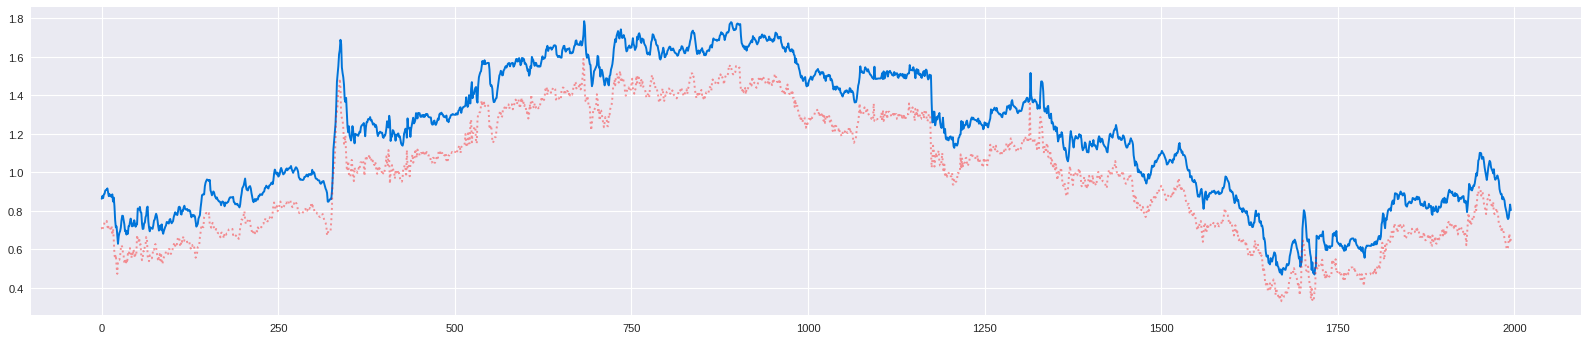

In [ ]:
# predicted_train = EncoderOnlyModel(dataset_train.x)
predicted_val = modelTest(dataset_val.x)


# plt.plot(normalized_data_close_price)
# plt.plot(predicted_train)
# plt.plot(predicted_val)

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))

# np.arange(len(predicted_train), len(predicted_train) + len(predicted_val)),
# plt.plot(np.arange(0,len(predicted_train)), predicted_train, color = config["plots"]["color_train"])
plt.plot(predicted_val, color = config["plots"]["color_val"])
# plt.plot(dataset_train.y, color = "red", linestyle = "dotted", alpha = 0.4)
plt.plot(dataset_val.y, color = "red", linestyle = "dotted", alpha = 0.4)

In [ ]:
dataset_train.x.shape

(7984, 20, 1)

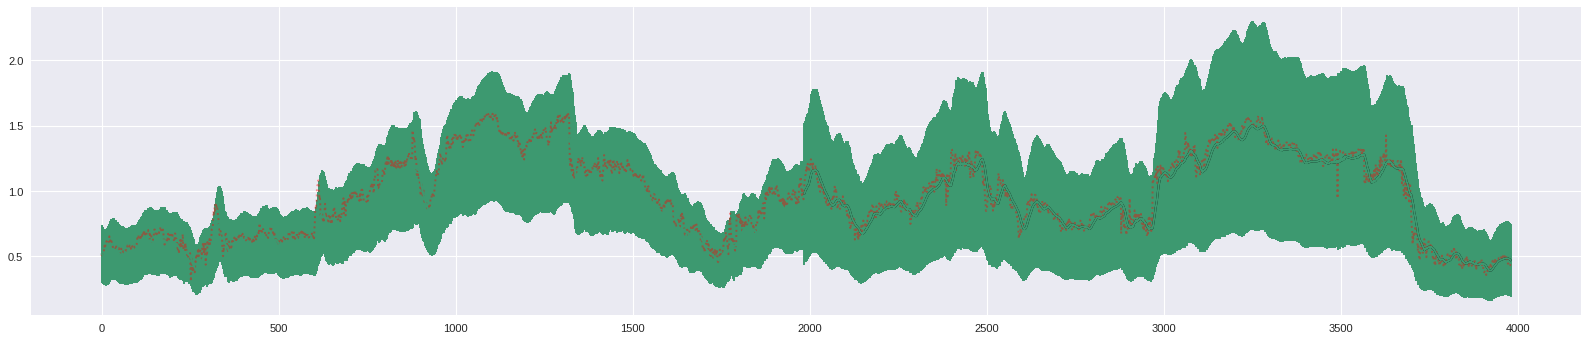

In [ ]:
num_ints = 10 

Xtrain = dataset_train.x[6000:7984, :, :]

train_int = np.zeros((Xtrain.shape[0], num_ints)) #dataset_train.x.shape[0]
train_val = np.zeros((dataset_val.x.shape[0], num_ints))



for i in range(num_ints):
  predicted_train = EncoderOnlyModel2(Xtrain)
  predicted_val = EncoderOnlyModel2(dataset_val.x)

  train_int[:, i] = predicted_train[:, 0] 
  train_val[:, i] = predicted_val[:, 0] 


  # plt.plot(normalized_data_close_price)
  # plt.plot(predicted_train)
  # plt.plot(predicted_val)

train_mean = np.mean(train_int, axis = 1)
train_sd = np.std(train_int, axis = 1)

val_mean = np.mean(train_val, axis = 1)
val_sd = np.std(train_val, axis = 1)

# plt.plot(np.arange(0,len(predicted_train)), predicted_train, color = config["plots"]["color_train"])
# plt.plot(np.arange(len(predicted_train), len(predicted_train) + len(predicted_val)), predicted_val, color = config["plots"]["color_val"])

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))

plt.errorbar(x = np.arange(0,len(predicted_train)), 
             y = train_mean, 
             yerr = 1.96*train_sd,
             color = config["plots"]["color_train"])

plt.errorbar(x = np.arange(len(predicted_train), len(predicted_train) + len(predicted_val)), 
             y = val_mean, 
             yerr = 1.96*val_sd,
             color = config["plots"]["color_train"])
plt.plot(np.arange(len(predicted_train), len(predicted_train) + len(predicted_val)), 
             val_mean, color = "black")
plt.plot(dataset_train.y[6000:7984, :], color = "red", linestyle = "dotted", alpha = 0.4)
plt.plot(np.arange(len(predicted_train), len(predicted_train) + len(predicted_val)), dataset_val.y, color = "red", linestyle = "dotted", alpha = 0.4)

# Decoder Only model

In [ ]:
input_shape = dataset_train.x.shape[1:]

seq_len = input_shape[0]

look_ahead_mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
look_ahead_mask = tf.expand_dims(look_ahead_mask, 0)  # add batch dimension
look_ahead_mask = tf.cast(look_ahead_mask, tf.bool)

def transformer_decoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    
    # Masked Multi-Head Attention
    # "MASKED ATTENTION LAYER"
    x = layers.LayerNormalization()(inputs) # epsilon=1e-6
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x, attention_mask=look_ahead_mask)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    
    # FEED FORWARD Part 
    x = layers.LayerNormalization()(res) 
    x = layers.Dense(ff_dim, activation = "relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x) 
    return x + res

    

In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    
    for _ in range(num_transformer_blocks):  # This is what stacks our transformer blocks
        x = transformer_decoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = tfp.layers.DenseVariational(
            units = dim, 
            make_posterior_fn = posterior_fn, 
            make_prior_fn = prior_fn, 
            kl_weight = 1/data_x_train.shape[0],
            activation = "relu"
            )(x) 
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(1, activation="linear")(x) #this is a pass-through
    return keras.Model(inputs, outputs)


In [ ]:
DecoderOnlyModel = build_model(
    input_shape,
    head_size=15,    # Embedding size for attention, 46
    num_heads=60,     #60, # Number of attention heads
    ff_dim=55,       #55, # Hidden layer size in feed forward network inside transformer
    num_transformer_blocks=2,
    mlp_units=[100],
    mlp_dropout=0.2,
    dropout=0.1,
)

DecoderOnlyModel.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mean_squared_error"],
)

In [ ]:
history = DecoderOnlyModel.fit(
    dataset_train.x,
    dataset_train.y,
    epochs=100,
    batch_size=512
)

Epoch 1/100


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.9/dist-packages/keras/backend.py", line 5160, in <genexpr>
    ta.write(ta_index_to_write, out)  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.9/dist-packages/keras/backend.py", line 5160, in <genexpr>
    ta.write(ta_index_to_write, out)  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrappe

16/16 [==============================] - 39s 2s/step - loss: 0.3310 - mean_squared_error: 0.3016
Epoch 2/100
16/16 [==============================] - 31s 2s/step - loss: 0.2578 - mean_squared_error: 0.2271
Epoch 3/100
16/16 [==============================] - 32s 2s/step - loss: 0.2917 - mean_squared_error: 0.2616
Epoch 4/100
16/16 [==============================] - 31s 2s/step - loss: 0.1903 - mean_squared_error: 0.1600
Epoch 5/100
16/16 [==============================] - 32s 2s/step - loss: 0.2327 - mean_squared_error: 0.2028
Epoch 6/100
16/16 [==============================] - 31s 2s/step - loss: 0.1723 - mean_squared_error: 0.1417
Epoch 7/100
16/16 [==============================] - 31s 2s/step - loss: 0.1307 - mean_squared_error: 0.1002
Epoch 8/100
16/16 [==============================] - 31s 2s/step - loss: 0.1448 - mean_squared_error: 0.1143
Epoch 9/100
16/16 [==============================] - 31s 2s/step - loss: 0.2454 - mean_squared_error: 0.2142
Epoch 10/100
16/16 [===========

In [ ]:
# Download 
DecoderOnlyModel.save_weights('DecoderOnlyModelAMZN.h5')
!zip -r /content/DecoderOnlyModelAMZN2.zip DecoderOnlyModelAMZN2
files.download("DecoderOnlyModelAMZN.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
DecoderOnlyModelAAPL = build_model(
    input_shape,
    head_size=15,    # Embedding size for attention, 46
    num_heads=60,     #60, # Number of attention heads
    ff_dim=55,       #55, # Hidden layer size in feed forward network inside transformer
    num_transformer_blocks=2,
    mlp_units=[100],
    mlp_dropout=0.2,
    dropout=0.1,
)

DecoderOnlyModelAAPL.load_weights('./DecoderOnlyModelAAPL.h5')

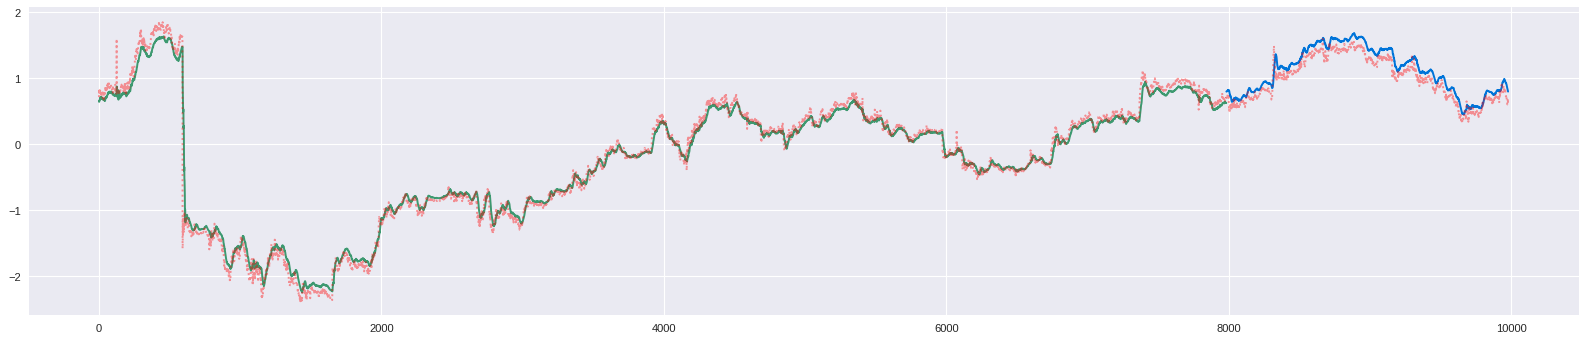

In [ ]:
predicted_train = DecoderOnlyModelAAPL(dataset_train.x)
predicted_val = DecoderOnlyModelAAPL(dataset_val.x)


# plt.plot(normalized_data_close_price)
# plt.plot(predicted_train)
# plt.plot(predicted_val)

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))

plt.plot(np.arange(0,len(predicted_train)), predicted_train, color = config["plots"]["color_train"])
plt.plot(np.arange(len(predicted_train), len(predicted_train) + len(predicted_val)), predicted_val, color = config["plots"]["color_val"])
plt.plot(dataset_train.y, color = "red", linestyle = "dotted", alpha = 0.4)
plt.plot(np.arange(len(predicted_train), len(predicted_train) + len(predicted_val)),dataset_val.y, color = "red", linestyle = "dotted", alpha = 0.4)

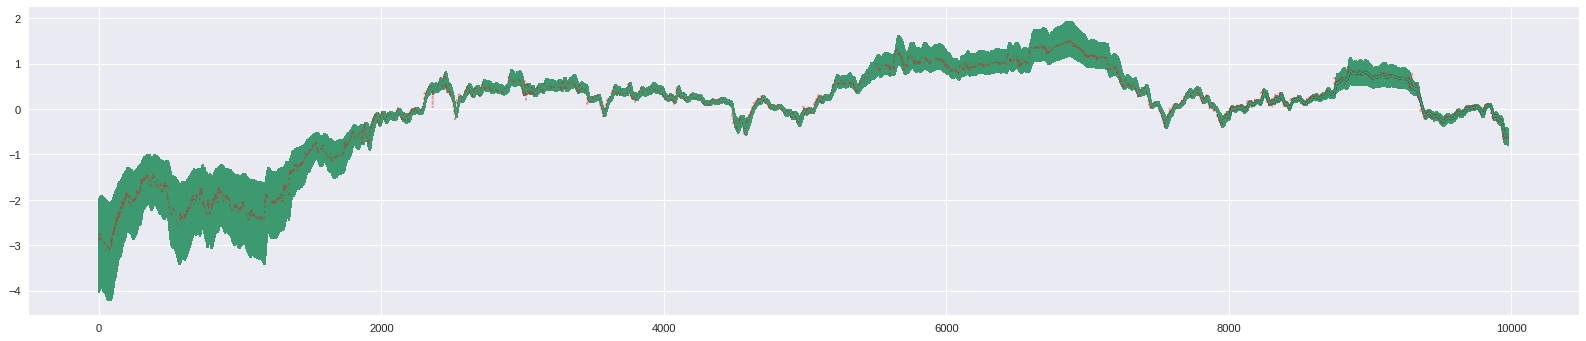

In [ ]:
plot_inferences(DecoderOnlyModel, num_ints = 20)

# Model Validation 

## Read in Models from .zips/.h5

In [ ]:
# Load in Models
!unzip LSTMBayesModelMSFT.zip
L = tf.keras.models.load_model('./content/LSTMBayesModelMSFT')

!unzip GRUBayesMSFT.zip
G = tf.keras.models.load_model('./content/GRUBayesMSFT')

!unzip LSTMAttBayesModelMSFT.zip
LA = tf.keras.models.load_model('./content/LSTMBayesModelMSFT')

!unzip EncoderOnlyModelMSFT.zip
EO = tf.keras.models.load_model('./content/EncoderOnlyModel2MSFT')

DO = build_model(
    input_shape,
    head_size=15,    
    num_heads=60,     
    ff_dim=55,      
    num_transformer_blocks=2,
    mlp_units=[100],
    mlp_dropout=0.2,
    dropout=0.1,
)

DO.load_weights('./DecoderOnlyModelMSFT.h5')

In [ ]:
def is_outlier(points, thresh=3):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

## Histogram of MSE

In [ ]:
def getResults(model):
  num_ints = 100

  preds = []

  for i in range(num_ints):
    predicted_val = model(dataset_val.x)
    preds.append(predicted_val.numpy().reshape(1,-1)[0].tolist())

  preds = np.array(preds)
  truth = dataset_val.y.reshape(1,1996)
  errors = np.abs(preds - np.repeat(truth, num_ints, axis = 0))

  error = np.mean(errors, axis = 0)
  sd = np.std(preds, axis = 0)
  ratio = np.divide(error,sd)

  return error, sd, ratio

In [ ]:
# Need to import in models L, G, EO, LA, DO, for LSTM, GRU, Encoder-Only, LSTM + Att, Decoder-Only

Berror, Bsd, Bratio = getResults(L)
Gerror, Gsd, Gratio = getResults(G)
EOerror, EOsd, EOratio = getResults(EO)
BAerror, BAsd, BAratio = getResults(LA)
DOerror, DOsd, DOratio = getResults(DO)

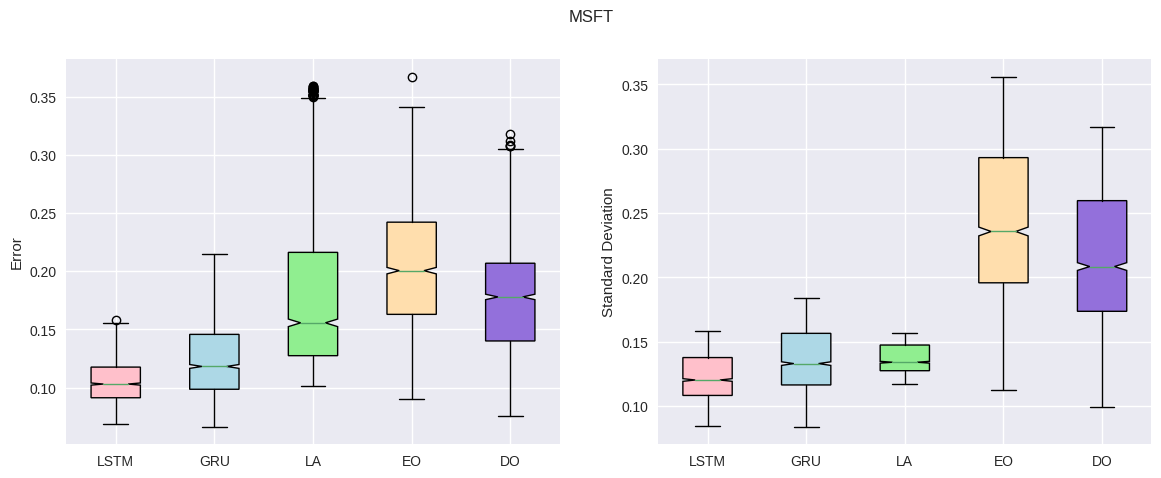

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
ax1, ax2 = axs
labels = ['LSTM', 'GRU', "LA", 'EO', "DO"]
colors = ['pink', 'lightblue', 'lightgreen', 'navajowhite', 'mediumpurple']

# Make sure Berror, etc have been read in from above code
bp1 = ax1.boxplot([ Berror[~is_outlier(Berror)], Gerror[~is_outlier(Gerror)], BAerror[~is_outlier(BAerror)], EOerror[~is_outlier(EOerror)], DOerror[~is_outlier(DOerror)] ],
            notch=True,  
            vert=True,  
            patch_artist=True, 
            labels=labels)
bp2 = ax2.boxplot([Bsd, Gsd, BAsd, EOsd, DOsd],
            notch=True,  
            vert=True,  
            patch_artist=True, 
            labels=labels)

ax1.set_ylabel('Error')
ax2.set_ylabel('Standard Deviation')
fig.suptitle(config["data"]["data_link"][0:4])

for bplot in (bp1, bp2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)


plt.show()

## Payoff Policy

In [ ]:
def inferences(model, num_infs):
  # number of validation points
  n_val = dataset_val.y.shape[0] 

  # validation set data over inferences
  val_dat = np.zeros(shape = (n_val, num_infs))
  
  Xtrain = dataset_val.x

  for inf in range(num_infs):

    y_pred = model(Xtrain)[:, 0]
    val_dat[:, inf] = y_pred

  std_val = np.std(val_dat, axis = 1)
  scaled_std = (std_val - np.min(std_val)) / (np.max(std_val) - np.min(std_val))
  mean_val = np.mean(val_dat, axis = 1)

  return mean_val, std_val, scaled_std

def payoff2(lag, mean_val, std_val, scaled_std):
  n_val = dataset_val.y.shape[0] 
  profit = 0 
  numTransact = 0
  for val in range(0, n_val - lag, 1):
    y_true_sell_price = dataset_val.y[val + lag, 0]

    if np.random.random() < 1 - np.mean(scaled_std[val:val+lag]) and np.mean(mean_val[val+int(lag/2):val+lag]) > mean_val[val]:
      trade_diff = y_true_sell_price - dataset_val.y[val, 0]
      profit += trade_diff
      numTransact += 1
    else:
      pass

  return profit, std_val, profit/numTransact, numTransact


def payoff(lag, mean_val, std_val):
  n_val = dataset_val.y.shape[0] 
  profit = 0 
  numTransact = 0

  curr = dataset_val.y[0, 0]
  inTrade = False

  purchasePrice = 0
  sellPrice = 0

  buys = []
  sells = []

  val = 1
  while val < n_val:

    z = np.random.normal(loc = np.mean(mean_val[val:val+lag]), scale=np.mean(std_val[val:val+lag]))
    # BUY signal
    if z >= curr and not inTrade:
      purchasePrice = dataset_val.y[val, 0]
      inTrade = True
      buys.append(val)
    # HOLD signal (in trade)
    elif z >= curr and inTrade:
      pass
    # SELL signal
    elif z < curr and inTrade:
      sellPrice = dataset_val.y[val, 0]
      profit += sellPrice - purchasePrice
      numTransact += 1
      inTrade = False
      sells.append(val)
    # HOLD signal (out of trade)
    else:
      pass
    
    curr = mean_val[val]
    val += lag

  return profit, profit/numTransact, numTransact, buys, sells


In [ ]:
def calculateProfitDistrib(lag, m, s):
  profits = []
  for i in range(1500):
    profit, _, _, _, _ = payoff(lag, m, s)
    profits.append(profit)
  return np.array(profits)

In [ ]:
# APPLE DATA
LmAAPL, LsAAPL, _ = inferences(L, 30)
GmAAPL, GsAAPL, _ = inferences(G, 30)
LAmAAPL, LAsAAPL, _ = inferences(LA, 30)
EOmAAPL, EOsAAPL, _ = inferences(EO, 30)
DOmAAPL, DOsAAPL, _ = inferences(DO, 30)

In [ ]:
LprofitsAAPL = calculateProfitDistrib(10, LmAAPL, LsAAPL)
GprofitsAAPL = calculateProfitDistrib(10, GmAAPL, GsAAPL)
LAprofitsAAPL = calculateProfitDistrib(10, LAmAAPL, LAsAAPL)
EOprofitsAAPL = calculateProfitDistrib(10, EOmAAPL, EOsAAPL)
DOprofitsAAPL = calculateProfitDistrib(10, DOmAAPL, DOsAAPL)

In [ ]:
# MICROSOFT DATA
LmMSFT, LsMSFT, _ = inferences(L, 30)
GmMSFT, GsMSFT, _ = inferences(G, 30)
LAmMSFT, LAsMSFT, _ = inferences(LA, 30)
EOmMSFT, EOsMSFT, _ = inferences(EO, 30)
DOmMSFT, DOsMSFT, _ = inferences(DO, 30)

In [ ]:
LprofitsMSFT = calculateProfitDistrib(10, LmMSFT, LsMSFT)
GprofitsMSFT = calculateProfitDistrib(10, GmMSFT, GsMSFT)
LAprofitsMSFT = calculateProfitDistrib(10, LAmMSFT, LAsMSFT)
EOprofitsMSFT = calculateProfitDistrib(10, EOmMSFT, EOsMSFT)
DOprofitsMSFT = calculateProfitDistrib(10, DOmMSFT, DOsMSFT)

In [ ]:
# AMAZON DATA
LmAMZN, LsAMZN, _ = inferences(L, 30)
GmAMZN, GsAMZN, _ = inferences(G, 30)
LAmAMZN, LAsAMZN, _ = inferences(LA, 30)
EOmAMZN, EOsAMZN, _ = inferences(EO, 30)
DOmAMZN, DOsAMZN, _ = inferences(DO, 30)

In [ ]:
LprofitsAMZN = calculateProfitDistrib(10, LmAMZN, LsAMZN)
GprofitsAMZN = calculateProfitDistrib(10, GmAMZN, GsAMZN)
LAprofitsAMZN = calculateProfitDistrib(10, LAmAMZN, LAsAMZN)
EOprofitsAMZN = calculateProfitDistrib(10, EOmAMZN, EOsAMZN)
DOprofitsAMZN = calculateProfitDistrib(10, DOmAMZN, DOsAMZN)

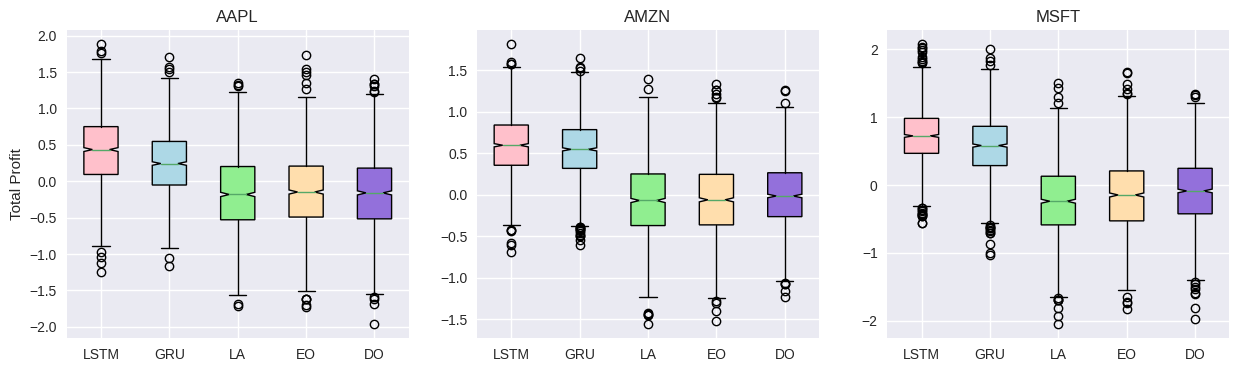

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
ax1, ax2, ax3 = axs
labels = ['LSTM', 'GRU', "LA", 'EO', "DO"]
colors = ['pink', 'lightblue', 'lightgreen', 'navajowhite', 'mediumpurple']

bp1 = ax1.boxplot([LprofitsAAPL, GprofitsAAPL, LAprofitsAAPL, EOprofitsAAPL, DOprofitsAAPL],
            notch=True,  
            vert=True,  
            patch_artist=True, 
            labels=labels)
bp2 = ax2.boxplot([LprofitsAMZN, GprofitsAMZN, LAprofitsAMZN, EOprofitsAMZN, DOprofitsAMZN],
            notch=True,  
            vert=True,  
            patch_artist=True, 
            labels=labels)
bp3 = ax3.boxplot([LprofitsMSFT, GprofitsMSFT, LAprofitsMSFT, EOprofitsMSFT, DOprofitsMSFT],
            notch=True,  
            vert=True,  
            patch_artist=True, 
            labels=labels)


ax1.set_title('AAPL')
ax1.set_ylabel('Total Profit')
ax2.set_title('AMZN')
ax3.set_title('MSFT')

for bplot in (bp1, bp2, bp3):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)


plt.show()

In [ ]:
p_temp1, _, _, buys1, sells1 = payoff(5, LmAAPL, LsAAPL)
print(p_temp1)
p_temp2, _, _, buys2, sells2 = payoff(25, LmAAPL, LsAAPL)
print(p_temp2)
p_temp3, _, _, buys3, sells3 = payoff(60, LmAAPL, LsAAPL)
print(p_temp3)

0.5127047002315521
0.502719521522522
0.8623667061328888


In [ ]:
def calculateProfitLags(lag, m, s):
  profits = []
  for i in range(2500):
    profit, _, _, _, _ = payoff(lag, m, s)
    profits.append(profit)
  return np.array(profits)

print(np.mean(calculateProfitLags(5, LmAAPL, LsAAPL)))
print(np.mean(calculateProfitLags(25, LmAAPL, LsAAPL)))
print(np.mean(calculateProfitLags(60, LmAAPL, LsAAPL)))

0.5287604575514794
0.5528088706016541
0.7166569981336594


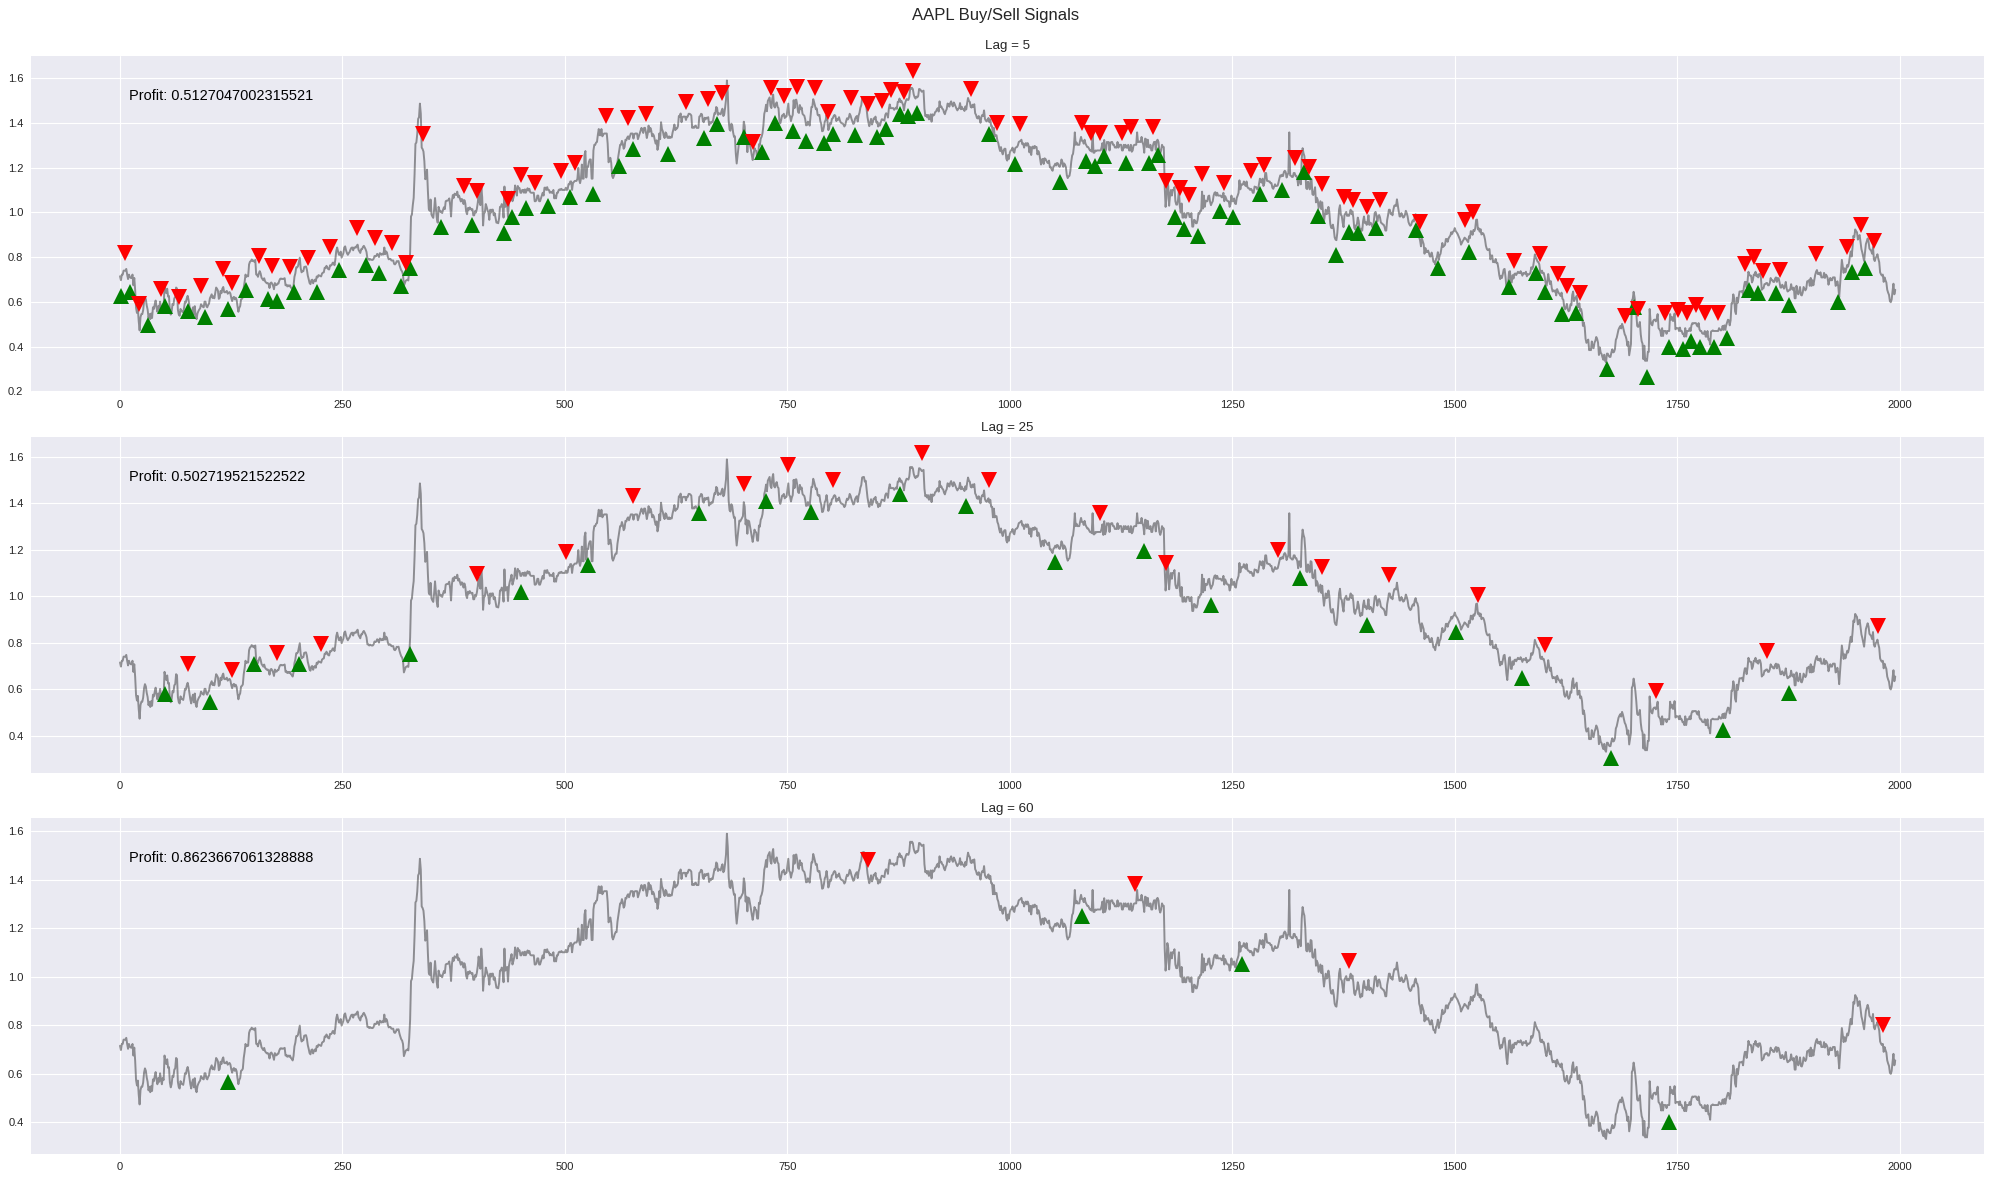

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(25, 15), dpi=80)
ax1, ax2, ax3 = axs
fig.patch.set_facecolor((1.0, 1.0, 1.0))


ax1.plot(np.arange(0, len(dataset_val.y)),dataset_val.y, color = "black", alpha = 0.4)
for b in buys1:
  ax1.plot(b, dataset_val.y[b]-0.07, "g^", markersize=15)
for s in sells1:
  ax1.plot(s, dataset_val.y[s]+0.08, "rv", markersize=15)
ax1.annotate('Profit: {}'.format(p_temp1), xy=(0.05, 0.87), xycoords='axes fraction', size=13, color = 'k')
ax1.set_title('Lag = 5')


ax2.plot(np.arange(0, len(dataset_val.y)),dataset_val.y, color = "black", alpha = 0.4)
for b in buys2:
  ax2.plot(b, dataset_val.y[b]-0.07, "g^", markersize=15)
for s in sells2:
  ax2.plot(s, dataset_val.y[s]+0.08, "rv", markersize=15)
ax2.annotate('Profit: {}'.format(p_temp2), xy=(0.05, 0.87), xycoords='axes fraction', size=13, color = 'k')
ax2.set_title('Lag = 25')


ax3.plot(np.arange(0, len(dataset_val.y)),dataset_val.y, color = "black", alpha = 0.4)
for b in buys3:
  ax3.plot(b, dataset_val.y[b]-0.07, "g^", markersize=15)
for s in sells3:
  ax3.plot(s, dataset_val.y[s]+0.08, "rv", markersize=15)
ax3.annotate('Profit: {}'.format(p_temp3), xy=(0.05, 0.87), xycoords='axes fraction', size=13, color = 'k')
ax3.set_title('Lag = 60')

fig.suptitle('AAPL Buy/Sell Signals\n', size = 15)
plt.tight_layout()